In [ ]:
import os, copy, math
import torch, torch.nn as nn, torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GLOBAL_MODEL_PATH = "global_model.pt"
CLIENTS_DIR = "client_updates"
os.makedirs(CLIENTS_DIR, exist_ok=True)

In [ ]:
num_clients = 20
num_rounds = 50
local_epochs = 2
batch_size = 64
lr = 0.01
mu = 0.05
dirichlet_alpha = 0.05
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [ ]:
def partition_dirichlet(dataset, num_clients, alpha):
    labels = np.array(dataset.targets)
    num_classes = int(labels.max()) + 1
    class_indices = [np.where(labels == c)[0] for c in range(num_classes)]
    client_indices = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        idx_c = class_indices[c]
        np.random.shuffle(idx_c)
        proportions = np.random.dirichlet([alpha] * num_clients)
        counts = (proportions * len(idx_c)).astype(int)

        remainder = len(idx_c) - counts.sum()
        if remainder > 0:
            for i in np.argsort(proportions)[-remainder:]:
                counts[i] += 1

        start = 0
        for client_id, cnt in enumerate(counts):
            if cnt > 0:
                client_indices[client_id].extend(idx_c[start:start+cnt].tolist())
                start += cnt
    return client_indices

In [ ]:
client_indices = partition_dirichlet(train_dataset, num_clients, dirichlet_alpha)
client_sizes = [len(idx) for idx in client_indices]
print("Client sizes:", client_sizes)

Client sizes: [3544, 45, 5196, 235, 8751, 10290, 1, 2100, 2659, 1219, 2364, 2519, 6672, 1899, 3050, 1021, 51, 846, 1140, 6398]


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def evaluate_model(model):
    model.eval()
    loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    correct, total = 0, 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(dim=1)
            total += y.size(0)
            correct += (pred == y).sum().item()
    return 100.0 * correct / total

In [ ]:
def save_client_update(model_state_dict, client_id, n_samples):
    save_path = os.path.join(CLIENTS_DIR, f"client_{client_id}.npz")
    np_state = {k: v.cpu().numpy() for k,v in model_state_dict.items()}
    np.savez(save_path, n_samples=n_samples, **np_state)

In [ ]:
def load_all_client_updates():
    files = [os.path.join(CLIENTS_DIR, f) for f in os.listdir(CLIENTS_DIR) if f.endswith(".npz")]
    updates = []
    for f in files:
        data = np.load(f, allow_pickle=True)
        n = int(data["n_samples"].tolist()) if "n_samples" in data else None
        param_dict = {k: data[k] for k in data.files if k != "n_samples"}
        updates.append((param_dict, n))
    return updates

In [ ]:
def clear_client_updates():
    for f in os.listdir(CLIENTS_DIR):
        path = os.path.join(CLIENTS_DIR, f)
        if os.path.isfile(path):
            os.remove(path)

In [ ]:
def fedavg(updates):
    if not updates:
        return None
    total_n = sum([n for (_, n) in updates])
    avg = {}
    for k in updates[0][0].keys():
        avg[k] = np.zeros_like(updates[0][0][k], dtype=np.float64)
    for (params, n) in updates:
        weight = n / total_n
        for k, v in params.items():
            avg[k] += v.astype(np.float64) * weight
    for k in avg.keys():
        avg[k] = avg[k].astype(np.float32)
    return avg

In [ ]:
def local_train_fedavg(client_id):
    model = CNN().to(device)
    model.load_state_dict(torch.load(GLOBAL_MODEL_PATH))
    model.train()
    loader = DataLoader(Subset(train_dataset, client_indices[client_id]), batch_size=batch_size, shuffle=True)
    opt = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for _ in range(local_epochs):
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
    save_client_update(model.state_dict(), client_id, len(client_indices[client_id]))

In [ ]:
def local_train_fedprox(client_id, global_state_dict, mu_local):
    model = CNN().to(device)
    model.load_state_dict(global_state_dict)
    model.train()
    loader = DataLoader(Subset(train_dataset, client_indices[client_id]), batch_size=batch_size, shuffle=True)
    opt = optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    global_params = {k: v.to(device) for k,v in global_state_dict.items()}
    for _ in range(local_epochs):
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            prox = 0.0
            for (name, param) in model.named_parameters():
                prox = prox + torch.sum((param - global_params[name])**2)
            loss = loss + (mu_local / 2.0) * prox
            loss.backward()
            opt.step()
    save_client_update(model.state_dict(), client_id, len(client_indices[client_id]))

In [ ]:
def server_init_model():
    model = CNN().to(device)
    torch.save(model.state_dict(), GLOBAL_MODEL_PATH)

In [ ]:
def server_aggregate(weighted=True):
    updates = load_all_client_updates()
    if not updates:
        return False
    if weighted:
        avg_numpy = fedavg(updates)
    else:
        total = len(updates)
        avg_numpy = {}
        for k in updates[0][0].keys():
            avg_numpy[k] = sum([upd[0][k].astype(np.float64) for upd in updates]) / total
            avg_numpy[k] = avg_numpy[k].astype(np.float32)
    avg_torch = {k: torch.tensor(v) for k,v in avg_numpy.items()}
    model = CNN().to(device)
    model.load_state_dict(avg_torch)
    torch.save(model.state_dict(), GLOBAL_MODEL_PATH)
    clear_client_updates()
    return True

In [ ]:
def run_fedavg_rounds(rounds):
    server_init_model()
    accuracies = []
    for r in range(rounds):
        for cid in range(num_clients):
            local_train_fedavg(cid)
        server_aggregate(weighted=True)
        model = CNN().to(device)
        model.load_state_dict(torch.load(GLOBAL_MODEL_PATH))
        acc = evaluate_model(model)
        accuracies.append(acc)
        print(f"FedAvg Round {r+1:02d} / {rounds}  acc={acc:.2f}%")
    return accuracies

In [ ]:
def run_fedprox_rounds(rounds, mu_local):
    server_init_model()
    accuracies = []
    for r in range(rounds):
        global_state = torch.load(GLOBAL_MODEL_PATH)
        for cid in range(num_clients):
            local_train_fedprox(cid, copy.deepcopy(global_state), mu_local)
        server_aggregate(weighted=True)
        model = CNN().to(device)
        model.load_state_dict(torch.load(GLOBAL_MODEL_PATH))
        acc = evaluate_model(model)
        accuracies.append(acc)
        print(f"FedProx (mu={mu_local}) Round {r+1:02d} / {rounds}  acc={acc:.2f}%")
    return accuracies

In [ ]:
acc_fedavg = run_fedavg_rounds(num_rounds)
acc_fedprox = run_fedprox_rounds(num_rounds, mu_local=mu)

FedAvg Round 01 / 50  acc=9.99%
FedAvg Round 02 / 50  acc=13.68%
FedAvg Round 03 / 50  acc=26.41%
FedAvg Round 04 / 50  acc=42.13%
FedAvg Round 05 / 50  acc=49.22%
FedAvg Round 06 / 50  acc=53.61%
FedAvg Round 07 / 50  acc=58.77%
FedAvg Round 08 / 50  acc=61.43%
FedAvg Round 09 / 50  acc=67.23%
FedAvg Round 10 / 50  acc=69.89%
FedAvg Round 11 / 50  acc=72.40%
FedAvg Round 12 / 50  acc=74.14%
FedAvg Round 13 / 50  acc=75.15%
FedAvg Round 14 / 50  acc=76.81%
FedAvg Round 15 / 50  acc=76.94%
FedAvg Round 16 / 50  acc=78.36%
FedAvg Round 17 / 50  acc=78.33%
FedAvg Round 18 / 50  acc=79.03%
FedAvg Round 19 / 50  acc=81.01%
FedAvg Round 20 / 50  acc=81.35%
FedAvg Round 21 / 50  acc=83.38%
FedAvg Round 22 / 50  acc=82.71%
FedAvg Round 23 / 50  acc=83.57%
FedAvg Round 24 / 50  acc=84.53%
FedAvg Round 25 / 50  acc=84.51%
FedAvg Round 26 / 50  acc=85.29%
FedAvg Round 27 / 50  acc=85.68%
FedAvg Round 28 / 50  acc=86.29%
FedAvg Round 29 / 50  acc=86.54%
FedAvg Round 30 / 50  acc=86.81%
FedAvg Roun

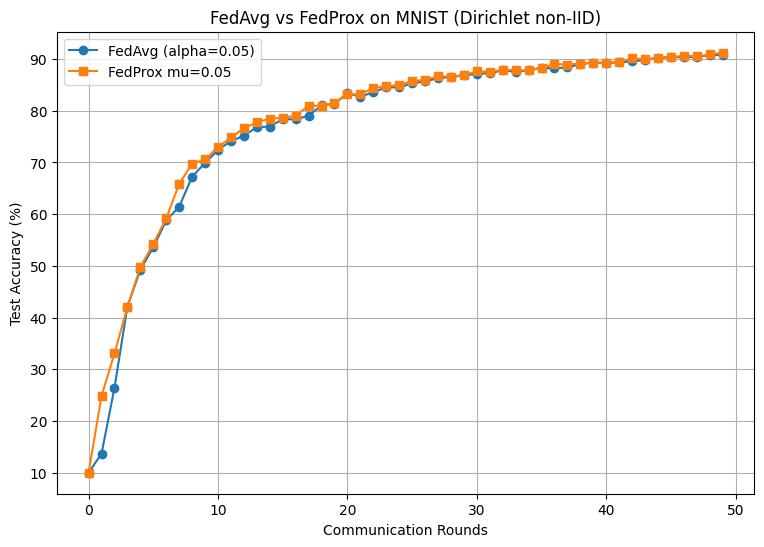

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(acc_fedavg, marker='o', label=f"FedAvg (alpha={dirichlet_alpha})")
plt.plot(acc_fedprox, marker='s', label=f"FedProx mu={mu}")
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy (%)")
plt.title("FedAvg vs FedProx on MNIST (Dirichlet non-IID)")
plt.legend()
plt.grid(True)
plt.show()